# 피마 인디언 당뇨병 예측 사례

#### 북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터
- Feature 설명
- Pregnancies: 임신 횟수
- Glucose: 포도당 부하 검사 수치
- BloodPressure: 혈압
- SkinThickness: 팔 삼두근 뒤쪽의 피하지방 측정값
- Insulin: 혈청 인슐린
- BMI: 체질량 지수(체중/키)
= DiabetesPedigreeFunction: 당뇨 내력 가중치 값
- Age: 나이
- Outcome: 클래스 결정 값

## 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
diabetes_data = pd.read_csv('../00.data/pima/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [3]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
feature_list = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
# 0 값들을 우선 NaN 값으로 교체
diabetes_data[feature_list] = diabetes_data[feature_list].replace(0, np.nan)

# 위 5개 feature 에 대해 0값을 평균 값으로 대체
mean_features = diabetes_data[feature_list].mean()
diabetes_data[feature_list] = diabetes_data[feature_list].replace(np.nan, mean_features)

In [5]:
diabetes_data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.00000,155.548223,33.6,0.627,50,1
1,1,85.0,66.0,29.00000,155.548223,26.6,0.351,31,0
2,8,183.0,64.0,29.15342,155.548223,23.3,0.672,32,1
3,1,89.0,66.0,23.00000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.00000,168.000000,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.00000,180.000000,32.9,0.171,63,0
764,2,122.0,70.0,27.00000,155.548223,36.8,0.340,27,0
765,5,121.0,72.0,23.00000,112.000000,26.2,0.245,30,0
766,1,126.0,60.0,29.15342,155.548223,30.1,0.349,47,1


### 정밀도(Precision)와 재현율(Recall)

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score #  precision_score(정밀도), recall_score(재현율)
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    AUC = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1 스코어: {f1:.4f}, AUC: {AUC:.4f}')

### 학습용 데이터와 테스트용 데이터 분리

In [8]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y 를 추출
X = diabetes_data.iloc[:, :-1]
y = diabetes_data['Outcome']

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
## 무작위 추출로 train, test set 분할
# 무작위 추출(random sampling, shuffle=True)하여 분할
# random_state 는 재현가능(for reproducibility)하도록 난수의 초기값을 설정해주는 것이며, 아무 숫자나 넣어주면 됨
# shuffle=True 가 디폴트 설정이므로 생략 가능
# 무작위 샘플링을 할지 선택하는 shuffle 옵션, 층화 추출법을 할 수 있는 stratify 옵션도 제공
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state = 156
)

### LogisticRegression(로지스틱 회귀) 학습/예측/평가

In [11]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[84 13]
 [26 31]]
정확도: 0.7468, 정밀도: 0.7045, 재현율: 0.5439, F1 스코어: 0.6139, AUC: 0.7049


#### 스케일링(StandardScaler)을 적용하여 변환
- 데이터 세트에 대해 피처 스케일링(StandardScaler)을 적용하여 변환(로지스틱 회귀의 경우, 숫자 데이터에 스케일링을 적용하는 것이 일반적으로 성능이 좋음)

In [12]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 상용하여 데이터 세트에 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터를 훈련과 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=156, stratify = y)

# 로지스틱 회귀로 학습, 예측, 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train,  y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[89 11]
 [21 33]]
정확도: 0.7922, 정밀도: 0.7500, 재현율: 0.6111, F1 스코어: 0.6735, AUC: 0.7506


In [36]:
""" 오차행렬:
 [[89 11]
 [21 33]]

정확도: 0.7922
정밀도: 0.7500
재현율: 0.6111
F1: 0.6735
AUC: 0.7506 """

' 오차행렬:\n [[89 11]\n [21 33]]\n\n정확도: 0.7922\n정밀도: 0.7500\n재현율: 0.6111\nF1: 0.6735\nAUC: 0.7506 '

### Precision/Recall Trade-off

In [14]:
pred_proba = lr_clf.predict_proba(X_test) 
pred_proba[:10, :] # 0될 확률 , 1 될 확률

array([[0.96503507, 0.03496493],
       [0.7943736 , 0.2056264 ],
       [0.85323013, 0.14676987],
       [0.38782466, 0.61217534],
       [0.58825549, 0.41174451],
       [0.24305881, 0.75694119],
       [0.18940876, 0.81059124],
       [0.84059022, 0.15940978],
       [0.77594956, 0.22405044],
       [0.88806555, 0.11193445]])

In [15]:
from sklearn.preprocessing import Binarizer

X = [[ 1, -1,  2],
     [ 2,  0,  0],
     [ 0,  1.1, 1.2]]

# threshold 기준값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)                     
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [16]:
custom_threshold = 0.5

# predict_proba( ) 반환값의 두번째 컬럼,
# 즉 Positive 클래스 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold)
custom_predict = binarizer.fit_transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[89 11]
 [21 33]]
정확도: 0.7922, 정밀도: 0.7500, 재현율: 0.6111, F1 스코어: 0.6735, AUC: 0.7506


In [17]:
# Binarizer의 threshold 설정값을 0.7으로 설정.
custom_threshold = 0.7
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold)
custom_predict = binarizer.fit_transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[96  4]
 [30 24]]
정확도: 0.7792, 정밀도: 0.8571, 재현율: 0.4444, F1 스코어: 0.5854, AUC: 0.7022


In [18]:
# Binarizer의 threshold 설정값을 0.48으로 설정.
custom_threshold = 0.48
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold)
custom_predict = binarizer.fit_transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[88 12]
 [20 34]]
정확도: 0.7922, 정밀도: 0.7391, 재현율: 0.6296, F1 스코어: 0.6800, AUC: 0.7548


### F1 스코어

In [19]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred)
print(f'F1 스코어: {f1:.4f}')

F1 스코어: 0.6735


### ROC AUC 스코어

In [20]:
roc_auc = roc_auc_score(y_test, pred)
print(f'ROC AUC 스코어: {roc_auc:.4f}')

ROC AUC 스코어: 0.7506


## 다른 방식 진행

### 데이터 불러오기

In [21]:
diabetes_data = pd.read_csv('../00.data/pima/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [22]:
# diabetes 데이터 갼략히 보기(feature type 및 Null 값 개수 보기)
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### 로지스틱 회귀를 이용한 예측모델 생성

In [23]:
# 분류를 위한 알고리즘인 로지스틱 회귀를 이용하여 예측 모델을 만듬
# 모델 평가를 위한 함수 설정

def get_clf_eval(y_test, y_pred):
  confusion = confusion_matrix(y_test, y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  F1 = f1_score(y_test, y_pred)
  AUC = roc_auc_score(y_test, y_pred)
  # 평가지표 출력
  print('오차행렬:\n', confusion)
  print('\n정확도: {:.4f}'.format(accuracy))
  print('정밀도: {:.4f}'.format(precision))
  print('재현율: {:.4f}'.format(recall))
  print('F1: {:.4f}'.format(F1))
  print('AUC: {:.4f}'.format(AUC))

#### 시각화를 위한 함수 설정

In [24]:
# Precision-Recall Curve Plot 그리기
def precision_recall_curve_plot(y_test, pred_proba):
  # threshold의 ndarray와 threshold 값별 정밀도, 재현율에 대한 ndarray 추출
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
  
  # x축을 threshold, y축을 정밀도, 재현율로 그래프 그리기
  plt.figure(figsize = (8, 6))
  thresholds_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[:thresholds_boundary], linestyle = "--", label = "precision")
  plt.plot(thresholds, recalls[:thresholds_boundary], linestyle = ":", label = 'recall')
  
  # thresholds의 값 X축 scale을 0.1 단위로 변경
  stard, end = plt.xlim()
  plt.xticks(np.round(np.arange(stard, end, 0.1), 2))
  
  plt.xlim()
  plt.xlabel('thresholds')
  plt.ylabel('precision & recall value')
  plt.legend()
  plt.grid()

#### x,y 데이터를 추출하고 훈련/테스트 데이터로 분리 작업 진행

In [25]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y 를 추출
X = diabetes_data.iloc[:, :-1]
y = diabetes_data['Outcome']

# 데이터를 훈련과 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify = y)

# 로지스틱 회귀로 학습, 예측 및 평가를 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬:
 [[88 12]
 [23 31]]

정확도: 0.7727
정밀도: 0.7209
재현율: 0.5741
F1: 0.6392
AUC: 0.7270


## 시각화

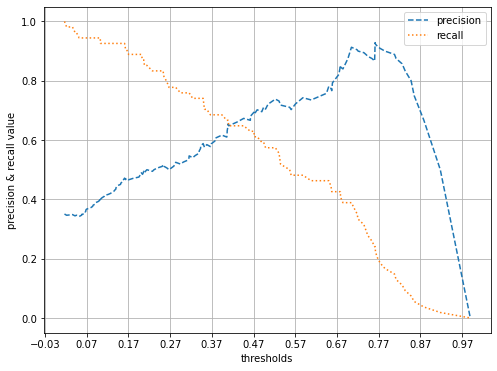

In [26]:
# 임계값별로 정밀도-재현율 출력
pred_proba = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba)

In [27]:
# 데이터의 기초 통계값들
# 최소 값이 0으로 되어 있는 값들이 많이 존재함
# Glucose(당 수치), BloodPressure(혈압), SkinThickness(피하지방), Insulin(인슐린), BMI(체질량 지수) 같은 값이 실제로 0일 수는 없다고 생각되므로 확인이 필요

diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [28]:
""" feature_list = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

def hist_plot(df):
    for col in feature_list:
        df[col].plot(kind='hist', bins=20).set_title('Histogram of '+col)
        plt.show()

hist_plot(diabetes_data) """

" feature_list = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']\n\ndef hist_plot(df):\n    for col in feature_list:\n        df[col].plot(kind='hist', bins=20).set_title('Histogram of '+col)\n        plt.show()\n\nhist_plot(diabetes_data) "

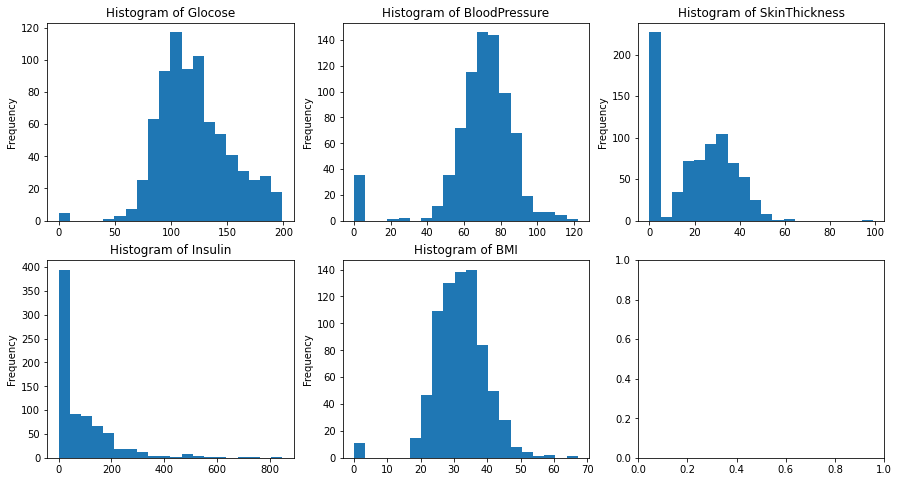

In [29]:
f, ax = plt.subplots(2, 3, figsize = (15, 8))
diabetes_data['Glucose'].plot(kind = 'hist', bins = 20, ax = ax[0, 0])
ax[0,0].set_title('Histogram of Glocose')
diabetes_data['BloodPressure'].plot(kind = 'hist', bins = 20, ax = ax[0, 1])
ax[0,1].set_title('Histogram of BloodPressure')
diabetes_data['SkinThickness'].plot(kind = 'hist', bins = 20, ax = ax[0, 2])
ax[0,2].set_title('Histogram of SkinThickness')
diabetes_data['Insulin'].plot(kind = 'hist', bins = 20, ax = ax[1, 0])
ax[1,0].set_title('Histogram of Insulin')
diabetes_data['BMI'].plot(kind = 'hist', bins = 20, ax = ax[1, 1])
ax[1,1].set_title('Histogram of BMI')

plt.show()

In [30]:
# 위 컬럼들에 대한 0 값의 비율 확인
feature_list = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
zero_count = []
zero_percent = []
for col in feature_list:
    zero_num = diabetes_data[diabetes_data[col]==0].shape[0]
    zero_count.append(zero_num)
    zero_percent.append(np.round(zero_num/diabetes_data.shape[0]*100,2))

zero = pd.DataFrame([zero_count, zero_percent], columns=feature_list, index=['count', 'percent']).T
zero

,count,percent
Glucose,5.0,0.65
BloodPressure,35.0,4.56
SkinThickness,227.0,29.56
Insulin,374.0,48.70
BMI,11.0,1.43


In [31]:
# 0 값들을 우선 NaN 값으로 교체
diabetes_data[feature_list] = diabetes_data[feature_list].replace(0, np.nan)

# 위 5개 feature 에 대해 0값을 평균 값으로 대체
mean_features = diabetes_data[feature_list].mean()
diabetes_data[feature_list] = diabetes_data[feature_list].replace(np.nan, mean_features)

In [32]:
# 데이터 세트에 대해 피처 스케일링(StandardScaler)을 적용하여 변환하기(로지스틱 회귀의 경우, 숫자 데이터에 스케일링을 적용하는 것이 일반적으로 성능이 좋음)
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 상용하여 데이터 세트에 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터를 훈련과 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=156, stratify = y)

# 로지스틱 회귀로 학습, 예측, 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train,  y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬:
 [[89 11]
 [21 33]]

정확도: 0.7922
정밀도: 0.7500
재현율: 0.6111
F1: 0.6735
AUC: 0.7506


In [33]:
# 평가지표를 조사하기 위한 새로운 함수 생성
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    #thresholds list 객체 내의 값을 iteration 하면서 평가 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('\n임계값: ', custom_threshold)
        get_clf_eval(y_test, custom_predict)

In [34]:
# 임계값 변화에 대한 예측 성능 확인
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)


임계값:  0.3
오차행렬:
 [[68 32]
 [10 44]]

정확도: 0.7273
정밀도: 0.5789
재현율: 0.8148
F1: 0.6769
AUC: 0.7474

임계값:  0.33
오차행렬:
 [[74 26]
 [11 43]]

정확도: 0.7597
정밀도: 0.6232
재현율: 0.7963
F1: 0.6992
AUC: 0.7681

임계값:  0.36
오차행렬:
 [[75 25]
 [13 41]]

정확도: 0.7532
정밀도: 0.6212
재현율: 0.7593
F1: 0.6833
AUC: 0.7546

임계값:  0.39
오차행렬:
 [[82 18]
 [16 38]]

정확도: 0.7792
정밀도: 0.6786
재현율: 0.7037
F1: 0.6909
AUC: 0.7619

임계값:  0.42
오차행렬:
 [[85 15]
 [18 36]]

정확도: 0.7857
정밀도: 0.7059
재현율: 0.6667
F1: 0.6857
AUC: 0.7583

임계값:  0.45
오차행렬:
 [[86 14]
 [19 35]]

정확도: 0.7857
정밀도: 0.7143
재현율: 0.6481
F1: 0.6796
AUC: 0.7541

임계값:  0.48
오차행렬:
 [[88 12]
 [20 34]]

정확도: 0.7922
정밀도: 0.7391
재현율: 0.6296
F1: 0.6800
AUC: 0.7548

임계값:  0.5
오차행렬:
 [[89 11]
 [21 33]]

정확도: 0.7922
정밀도: 0.7500
재현율: 0.6111
F1: 0.6735
AUC: 0.7506


#### 정확도, 정밀도, 재현율, F1, AUC 등의 평가 지표를 보고 적절히 판단하여 임계값을 재 설정하여 예측을 수행할 수 있음

In [35]:
# 임계값을 0.48로 설정하여 예측 수행
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 predict_proba() 예측확률의 array에서 1에 해당하는 컬럼 값을 대입하여 Binarizer를 이용하여 예측값 반환하기
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))

get_clf_eval(y_test, pred_th_048)

오차행렬:
 [[88 12]
 [20 34]]

정확도: 0.7922
정밀도: 0.7391
재현율: 0.6296
F1: 0.6800
AUC: 0.7548
